In [1]:
import pandas as pd
import pickle
import csv
import numpy as np
from datetime import datetime
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def read_float(field_str):
    if field_str == "NULL":
        return np.nan
    if field_str == "\\N":
        return -1
    try:
        return float(field_str)
    except:
        print("Could not convert {} to float".format(field_str))

def read_str(field_str):
    if field_str == "NULL":
        return np.nan
    return field_str

def read_datetime(field_str):
    if field_str == "NULL":
        return np.nan
    try:
        if len(field_str) == 19:
            field_str += ".0000"
        return datetime.fromisoformat(field_str[:-1])
    except:
        print("Could not convert {} to datetime".format(field_str))

def get_filename(year, month):
    year_str = str(year)
    month_str = str(month)
    if month < 10:
        month_str = "0" + month_str

    datafile_path = "data/{}{}-bluebikes-tripdata.csv".format(year_str, month_str)
    if year < 2018 or (year == 2018 and month < 5):
        datafile_path = "data/{}{}-hubway-tripdata.csv".format(year_str, month_str)
    return datafile_path

def load_pd(year, month):
    rides = []
    filename = get_filename(year, month)
    with open(filename, "r") as csvFile:
        csvreader = csv.reader(csvFile)
        is_header = True
        header = []
        for row in csvreader:
            if is_header:
                is_header = False
                header = row
                continue
            lambdas = [read_float, #tripduration
                       read_datetime, #starttime
                       read_datetime, #stoptime
                       read_str, #start station id
                       read_str, #start station name
                       read_float, #start station latitude
                       read_float, #start station longitude
                       read_str, #end station id
                       read_str, #end station name
                       read_float, #end station latitude
                       read_float, #end station longitude
                       read_str, #bikeid
                       read_str, #usertype
                      ]
            if year < 2020 or (year == 2020 and month < 5):
                lambdas.append(read_float) #birthyear
                lambdas.append(read_str) #gender
            else:
                lambdas.append(read_str) #postalcode
            assert len(row) == len(header)
            rides.append({header[i]: lambdas[i](row[i]) for i in range(len(header))})
            
            #path_id
            path_id = ""
            if rides[-1]["start station id"] != "\\N" and rides[-1]["end station id"] != "\\N":
                start_id_int = int(rides[-1]["start station id"])
                end_id_int = int(rides[-1]["end station id"])
                if start_id_int < end_id_int:
                    path_id = "{}-{}".format(start_id_int, end_id_int)
                else:
                    path_id = "{}-{}".format(end_id_int, start_id_int)
            rides[-1]["pathid"] = path_id
        return pd.DataFrame(rides)

def preprocess_rides(rides_pd):
    # Post-processing
    rides_pd["startdate"] = [datetime.date(dt) for dt in rides_pd["starttime"]]
    rides_pd["is_weekday"] = [dt.weekday()<5 for dt in rides_pd["starttime"]]
    length_threshold = 60 * 60  *2
    rides_pd["invalid"] = (rides_pd["tripduration"] > length_threshold) |\
                        (rides_pd["start station id"] == np.nan) |\
                        (rides_pd["end station id"] == np.nan)
    print("{:0.3f} invalid rides".format(np.sum(rides_pd["invalid"]) / len(rides_pd)))

def largest_category(df, key, categories, prefix=""):
    values = []
    for category in categories:
        values.append(df.loc[key][prefix + category])
    return categories[np.argmax(values)]

rides_pd = load_pd(2022, 10)
preprocess_rides(rides_pd)
rides_pd.head(n=1)

0.006 invalid rides


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,pathid,startdate,is_weekday,invalid
0,1300.0,2022-10-01 00:00:05.789,2022-10-01 00:21:46.532,471,MIT Carleton St at Amherst St,42.360542,-71.086698,492,Harvard Stadium: N. Harvard St at Soldiers Fie...,42.368019,-71.1242,7269,Subscriber,60101,471-492,2022-10-01,False,False


In [3]:
races = ["Hispanic or Latino", "White", "Black", "American Indian", "Asian"]
station_census_df = pd.read_csv("data/stations_tracts.csv",
                                index_col="Station Id")
print(station_census_df.shape)
station_census_df.index = station_census_df.index.astype("str")
station_census_df.head(n = 1)

(515, 30)


,Countyfp,Geoid,Intptlat,Intptlon,Station Name,NAME (DECENNIALPL2020.P2-Data.csv),Name1,Namelsad,Tractce,Aland,...,Total White,Percentage White,Total Black,Percentage Black,Total American Indian,Percentage American Indian,Total Asian,Percentage Asian,Total Hawaiian,Percentage Hawaiian
Station Id,,,,,,,,,,,,,,,,,,,,,
59,25,25025070202,42.350066,-71.06196,Chinatown Gate Plaza - Surface Rd. at Beach St.,"Census Tract 702.02, Suffolk County, Massachus...",702.02,Census Tract 702.02,70202,178542,...,1608,0.294505,186,0.034066,2,0.000366,3107,0.569048,4,0.000733


In [4]:
station_census_df["Race"] = [largest_category(station_census_df, station_id, races, prefix="Percentage ")\
                                 for station_id in station_census_df.index]
station_census_df_races = station_census_df["Race"]
rides_pd = rides_pd.join(station_census_df_races, on="start station id", how="left")
rides_pd.groupby("Race")["tripduration"].count()

Race
Asian                  38694
Black                   9691
Hispanic or Latino     15247
White                 353332
Name: tripduration, dtype: int64

In [5]:
stations_df = pd.read_csv("stations.csv")[["id", "Name", "Lat", "Long"]]
stations_df["id"] = [str(station_id) for station_id in stations_df["id"]]
stations_df = stations_df.set_index("id")
stations_df = stations_df.join(station_census_df["Race"])
stations_df.to_csv("station_races.csv")
#station_census_df[["Station Name", "Intptlat", "Intptlon", "Race"]].to_csv("station_races.csv")

In [6]:
## Export network
# Origin/Destination, Station Name, Path ID, Lat, Long, Weight
all_stations_pd = rides_pd[['start station id', 'start station name', 'start station latitude', 'start station longitude']]
unique_stations_pd = all_stations_pd.groupby("start station id").first()

station_name_to_id = {station_census_df.loc[station_id]["Station Name"] : station_id for station_id in station_census_df.index}
station_name_to_id = {}
for station_id in station_census_df.index:
    name = station_census_df.loc[station_id]["Station Name"]
    if name not in station_name_to_id:
        station_name_to_id[name] = []
    station_name_to_id[name].append(station_id)
    
station_id_to_name = {station_id : station_census_df.loc[station_id]["Station Name"] for station_id in station_census_df.index}

with open("intermediates/station_name_to_id.pickle", "wb") as pickleFile:
    pickle.dump(station_name_to_id, pickleFile)
with open("intermediates/station_census_df.pickle", "wb") as pickleFile:
    pickle.dump(station_census_df, pickleFile)
    
for station_name in station_name_to_id:
    if len(station_name_to_id[station_name]) > 1:
        print("{}: {}".format(station_name, station_name_to_id[station_name]))

Boylston St at Jersey St: ['247', '342']
One Brigham Circle: ['284', '359']
Harvard Ave at Brainerd Rd: ['168', '332']
Commonwealth Ave at Kelton St: ['243', '338']
Deerfield St at Commonwealth Ave: ['361', '294']
Charlestown Navy Yard: ['277', '356']
Medford St at Charlestown BCYF: ['281', '358']
Harvard St at Greene-Rose Heritage Park: ['240', '335']
Washington St at Egremont Rd: ['264', '354']
Broadway T Stop: ['366', '307']
Washington St at Myrtle St: ['231', '329']
Mass Ave at Hadley/Walden: ['238', '334']
Faneuil St at Arlington St: ['351', '262']
Main St at Thompson Sq: ['283', '327']
Huntington Ave at Mass Art: ['155', '331']
699 Mt Auburn St: ['237', '333']
Codman Square Library: ['257', '350']
Cleveland Circle: ['252', '346']
Commonwealth Ave at Chiswick Rd: ['249', '344']
Bartlett St at John Elliot Sq: ['360', '293']
Grove St at Community Path: ['220', '328']
Columbia Rd at Tierney Community Center: ['295', '362']
Centre St at Seaverns Ave: ['278', '357']
Roslindale Village 

In [7]:
len(station_id_to_name)

515

## Summary

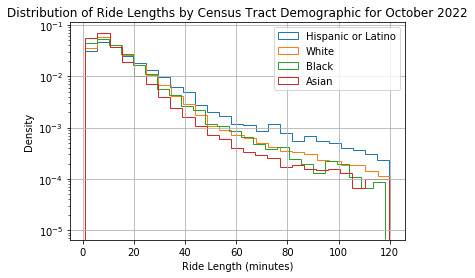

In [8]:
# distribution of trip durations

#(rides_pd[rides_pd["invalid"] == False]["tripduration"]).hist(bins=100, log=True, histtype="step", density=True)

fig, ax = plt.subplots()
for race in races:
    rides_pd_subset = rides_pd[(rides_pd["invalid"] == False) & (rides_pd["Race"] == race)].copy()
    rides_pd_subset["tripduration"] /= 60
    #rides_pd_subset["tripduration"]  = rides_pd_subset["tripduration"] / 60
    if len(rides_pd_subset) == 0:
        continue
    rides_pd_subset.hist(column="tripduration", label=race, bins=25, log=True, histtype="step", density=True, ax=ax)
ax.legend()
ax.set_title("Distribution of Ride Lengths by Census Tract Demographic for October 2022")
ax.set_ylabel("Density")
ax.set_xlabel("Ride Length (minutes)")
plt.savefig("figs/ride_length_distribution.pdf", bbox_inches="tight")
# for race in races:
#     rides_pd_subset = rides_pd[(rides_pd["invalid"] == False) & (rides_pd["Race"] == race)]
#     print(race)
#     print("%i Rides" % len(rides_pd_subset))
#     if len(rides_pd_subset) == 0:
#         print("\n")
#         continue
#     ratio = np.sum(rides_pd_subset["is_weekday"]) / len(rides_pd_subset)
#     print("Percentage weekday: {:0.3f}".format(ratio))
    
#     ratio = np.sum(rides_pd_subset["usertype"] == "Subscriber") / len(rides_pd_subset)
#     print("Percentage subscribers: {:0.3f}".format(ratio))
    
#     print("\n")



In [9]:
datetime(year=year, month=month, day=1)

NameError: name 'year' is not defined

In [10]:
num_rides_by_race = []
weekday_by_race = []
subscriber_by_race = []

for year in range(2015, 2023):
    for month in range(1, 13):
        if year == 2022 and month > 10:
            continue
        print("{} {}".format(year, month))
        rides_pd_month = load_pd(year, month)
        preprocess_rides(rides_pd_month)
        rides_pd_month["is_subscriber"] = rides_pd_month["usertype"] == "Subscriber"
        
        
        ## Number of Rides
        counts_month_pd = rides_pd_month[rides_pd_month["invalid"] == False].join(station_census_df_races,
                                                                on="start station id", how="left")\
            .groupby("Race")["tripduration"]\
            .count()
        counts_month_dict = {}
        for race in races:
            if race in counts_month_pd.index:
                counts_month_dict[race] = counts_month_pd.loc[race]
            else:
                counts_month_dict[race] = 0
        counts_month_dict["Date"] = datetime(year=year, month=month, day=1)
        num_rides_by_race.append(counts_month_dict)
        
        ## Weekday Ride
        
        avg_weekday_month_pd = rides_pd_month[rides_pd_month["invalid"] == False].join(station_census_df_races,
                                                                on="start station id", how="left")\
            .groupby("Race")["is_weekday"]\
            .mean()
        weekday_month_dict = {}
        for race in races:
            if race in avg_weekday_month_pd.index:
                weekday_month_dict[race] = avg_weekday_month_pd.loc[race]
            else:
                weekday_month_dict[race] = 0
        weekday_month_dict["Date"] = datetime(year=year, month=month, day=1)
        weekday_by_race.append(weekday_month_dict)
        
        ## Subscriber
    
        avg_subscriber_month_pd = rides_pd_month[rides_pd_month["invalid"] == False].join(station_census_df_races,
                                                                on="start station id", how="left")\
            .groupby("Race")["is_subscriber"]\
            .mean()
        subscriber_month_dict = {}
        for race in races:
            if race in avg_subscriber_month_pd.index:
                subscriber_month_dict[race] = avg_subscriber_month_pd.loc[race]
            else:
                subscriber_month_dict[race] = 0
        subscriber_month_dict["Date"] = datetime(year=year, month=month, day=1)
        subscriber_by_race.append(subscriber_month_dict)

2015 1
0.003 invalid rides
2015 2
0.003 invalid rides
2015 3
0.003 invalid rides
2015 4
0.006 invalid rides
2015 5
0.005 invalid rides
2015 6
0.005 invalid rides
2015 7
0.006 invalid rides
2015 8
0.006 invalid rides
2015 9
0.008 invalid rides
2015 10
0.007 invalid rides
2015 11
0.007 invalid rides
2015 12
0.006 invalid rides
2016 1
0.006 invalid rides
2016 2
0.007 invalid rides
2016 3
0.010 invalid rides
2016 4
0.010 invalid rides
2016 5
0.009 invalid rides
2016 6
0.008 invalid rides
2016 7
0.009 invalid rides
2016 8
0.007 invalid rides
2016 9
0.006 invalid rides
2016 10
0.004 invalid rides
2016 11
0.004 invalid rides
2016 12
0.003 invalid rides
2017 1
0.005 invalid rides
2017 2
0.005 invalid rides
2017 3
0.003 invalid rides
2017 4
0.010 invalid rides
2017 5
0.009 invalid rides
2017 6
0.010 invalid rides
2017 7
0.011 invalid rides
2017 8
0.009 invalid rides
2017 9
0.007 invalid rides
2017 10
0.007 invalid rides
2017 11
0.004 invalid rides
2017 12
0.002 invalid rides
2018 1
0.003 invali

In [11]:
colors = {"White" : "#76B7B2",
         "Asian": "#4E79A7",
         "Black" : "#F28E2B",
         "Hispanic or Latino" : "#E15759"
         }

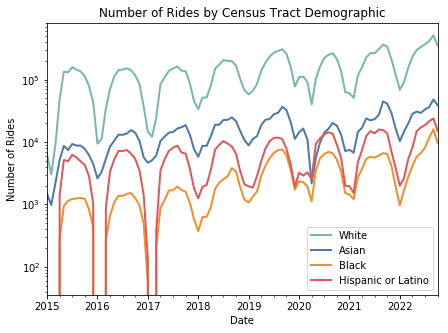

In [12]:
num_rides_by_race_pd = pd.DataFrame(num_rides_by_race)
num_rides_by_race_pd = num_rides_by_race_pd.set_index("Date")

fig, ax = plt.subplots(figsize=(7, 5))

for race in colors:
    num_rides_by_race_pd[race].plot(logy=True, ax=ax, c = colors[race], linewidth = 2)
ax.set_ylabel("Number of Rides")
ax.set_title("Number of Rides by Census Tract Demographic")
ax.legend()
plt.savefig("figs/num_rides_by_demographic.pdf", bbox_inches="tight")

# total_rides = np.zeros(len(num_rides_by_race_pd))
# for race in races:
#     total_rides += num_rides_by_race_pd[race]
# num_rides_by_race_pd["Total"] = total_rides

# fig, ax = plt.subplots(figsize=(7, 5))
# for race in ["White", "Black", "Hispanic or Latino", "Asian"]:
#     (num_rides_by_race_pd[race] / num_rides_by_race_pd["Total"]).plot(label=race, logy=True)
# ax.legend()    
# for race in races:
#     num_rides_by_race_pd[race] = num_rides_by_race_pd[race] / num_rides_by_race["Total"]
# num_rides_by_race_pd[races].plot(ax=ax)

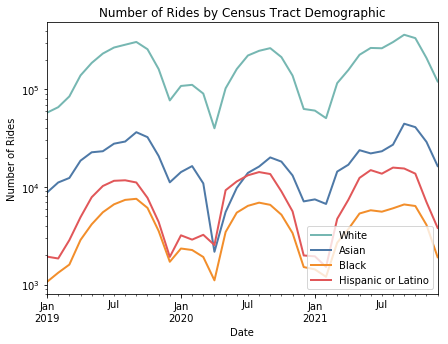

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
start_idx = 12 * 4
stop_idx = 12 * 7
for race in colors:
    num_rides_by_race_pd.iloc[start_idx:stop_idx][race].plot(logy=True, ax=ax, c = colors[race], linewidth=2)
ax.legend()
ax.set_ylabel("Number of Rides")
ax.set_title("Number of Rides by Census Tract Demographic")
plt.savefig("figs/num_rides_by_demographic_COVID.pdf", bbox_inches="tight")

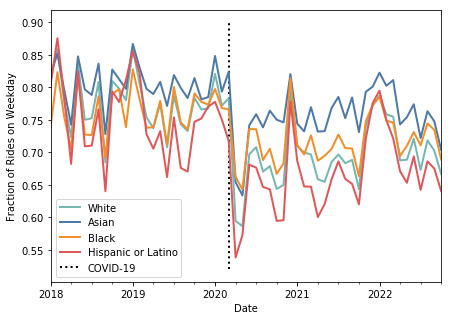

In [14]:
weekday_by_race_pd = pd.DataFrame(weekday_by_race)
weekday_by_race_pd = weekday_by_race_pd.set_index("Date")

fig, ax = plt.subplots(figsize=(7, 5))
for race in colors:
    weekday_by_race_pd.iloc[36:][race].plot(ax=ax, c = colors[race], linestyle = "-", linewidth = 2)
ax.set_ylabel("Fraction of Rides on Weekday")
ax.vlines(x = datetime(2020, 3, 20), ymin = 0.52, ymax = 0.9, linestyle = ":", linewidth = 2, label = "COVID-19")
ax.legend()

plt.savefig("figs/fraction_weekday_by_demographic.pdf", bbox_inches="tight")

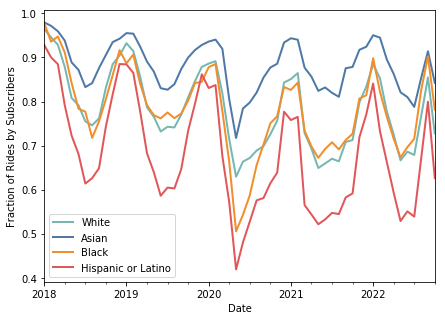

In [15]:
subscriber_by_race_pd = pd.DataFrame(subscriber_by_race)
subscriber_by_race_pd = subscriber_by_race_pd.set_index("Date")

fig, ax = plt.subplots(figsize=(7, 5))
for race in colors:
    subscriber_by_race_pd.iloc[36:][race].plot(ax=ax, c = colors[race], linewidth = 2)
ax.legend()
ax.set_ylabel("Fraction of Rides by Subscribers")
plt.savefig("figs/fraction_subscriber_by_demographic.pdf", bbox_inches="tight")

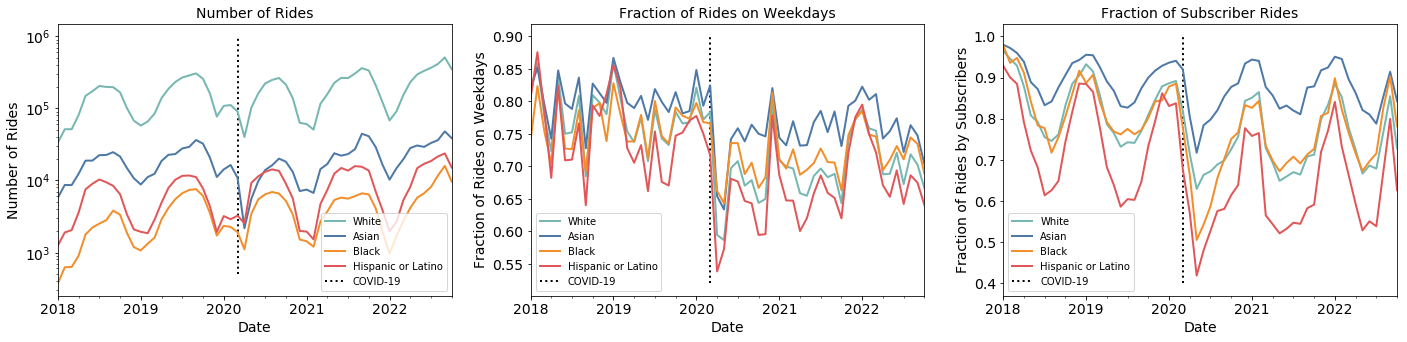

In [16]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(ncols = 3, figsize=(8 * 3, 5))

# Number of rides
for race in colors:
    num_rides_by_race_pd.iloc[36:][race].plot(logy=True, ax=ax[0], c = colors[race], linewidth = 2)
ax[0].set_ylabel("Number of Rides")
ax[0].set_title("Number of Rides")
ax[0].vlines(x = datetime(2020, 3, 20), ymin = 500, ymax = 10**6, linestyle = ":", linewidth = 2, label = "COVID-19")
ax[0].legend()

# Weekday Rides
for race in colors:
    weekday_by_race_pd.iloc[36:][race].plot(ax=ax[1], c = colors[race], linewidth = 2)
ax[1].set_ylabel("Fraction of Rides on Weekdays")
ax[1].set_title("Fraction of Rides on Weekdays")
ax[1].vlines(x = datetime(2020, 3, 20), ymin = 0.52, ymax = 0.9, linestyle = ":", linewidth = 2, label = "COVID-19")
ax[1].legend()

#Subscribes
for race in colors:
    subscriber_by_race_pd.iloc[36:][race].plot(ax=ax[2], c = colors[race], linewidth = 2)
ax[2].vlines(x = datetime(2020, 3, 20), ymin = 0.4, ymax = 1, linestyle = ":", linewidth = 2, label = "COVID-19")
ax[2].legend()
ax[2].set_ylabel("Fraction of Rides by Subscribers")
ax[2].set_title("Fraction of Subscriber Rides")

plt.savefig("figs/disaggregate_by_demographic.pdf", bbox_inches="tight")


In [27]:
print("Number of Rides")
for race in colors:
    mean_2019 = np.mean(num_rides_by_race_pd.iloc[48:58][race])
    mean_2022 = np.mean(num_rides_by_race_pd.iloc[84:][race])
    print("Race: {} 2019 Avg Rides: {} 2022 Avg Rides: {} Percent Change: {}".format(race,
                                                                 mean_2019,
                                                                 mean_2022,
                                                                 (mean_2022 - mean_2019) / mean_2019))
print()

print("Weekday Rides")
for race in colors:
    mean_2019 = np.mean(weekday_by_race_pd.iloc[48:58][race])
    mean_2022 = np.mean(weekday_by_race_pd.iloc[84:][race])
    print("Race: {} 2019 Avg Weekday: {} 2022 Avg Weekday: {} Percent Change: {}".format(race,
                                                                 mean_2019,
                                                                 mean_2022,
                                                                 (mean_2022 - mean_2019)))
print()
print("Subscribers")
for race in colors:
    mean_2019 = np.mean(subscriber_by_race_pd.iloc[48:58][race])
    mean_2022 = np.mean(subscriber_by_race_pd.iloc[84:][race])
    print("Race: {} 2019 Avg Subscriber: {} 2022 Avg Subscriber: {} Percent Change: {}".format(race,
                                                                 mean_2019,
                                                                 mean_2022,
                                                                 (mean_2022 - mean_2019)))

Number of Rides
Race: White 2019 Avg Rides: 188544.3 2022 Avg Rides: 281389.6 Percent Change: 0.4924322824927616
Race: Asian 2019 Avg Rides: 22276.8 2022 Avg Rides: 28862.9 Percent Change: 0.2956483875601524
Race: Black 2019 Avg Rides: 4426.4 2022 Avg Rides: 6735.3 Percent Change: 0.52162027833002
Race: Hispanic or Latino 2019 Avg Rides: 7186.1 2022 Avg Rides: 12887.8 Percent Change: 0.7934345472509426

Weekday Rides
Race: White 2019 Avg Weekday: 0.7685548970662903 2022 Avg Weekday: 0.7159109095258164 Percent Change: -0.05264398754047395
Race: Asian 2019 Avg Weekday: 0.8080169621982135 2022 Avg Weekday: 0.7644263096652457 Percent Change: -0.04359065253296779
Race: Black 2019 Avg Weekday: 0.7649901855118337 2022 Avg Weekday: 0.729508268946097 Percent Change: -0.03548191656573674
Race: Hispanic or Latino 2019 Avg Weekday: 0.735345592538032 2022 Avg Weekday: 0.6928205854507755 Percent Change: -0.04252500708725648

Subscribers
Race: White 2019 Avg Subscriber: 0.805270147547884 2022 Avg Sub

<AxesSubplot:xlabel='startdate'>

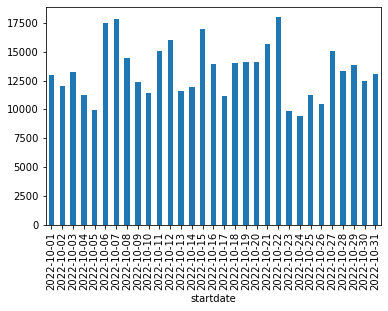

In [68]:
# distribution of trips by date
rides_pd[rides_pd["invalid"] == False].groupby("startdate").count()["tripduration"].plot.bar()

## Network Analysis

In [26]:
def create_station_network(year, month):
    rides_pd = load_pd(year, month)
    preprocess_rides(rides_pd)
    pairs = rides_pd[rides_pd["invalid"] == False].groupby([\
        "start station name", "end station name"])\
    .count()

    stations = [station[0][0] for station in rides_pd[rides_pd["invalid"] == False]\
                .groupby(["start station name", "start station id"])]
    assert len(stations) == len(set(stations))
    station_name_to_id = {station[0][0] : station[0][1] for station in rides_pd[rides_pd["invalid"] == False]\
                .groupby(["start station name", "start station id"])}
    # Technically: need to check end stations too. If not, the edge might add in a node that does not exist, which
    # means the node will not have an id.
    
    rides_G = nx.DiGraph()
    for station_name in station_name_to_id:
        rides_G.add_node(station_name, station_id = station_name_to_id[station_name])
    
    for start, end in pairs.index:
        rides_G.add_edge(start, end, weight=pairs.loc[start, end]["tripduration"])
    print("Year: {} Month: {} n={} m={}".format(year,
                                         month,
                                         len(rides_G),
                                         len(rides_G.edges)))
    return rides_G

In [35]:
station_networks = {}
for year in range(2015, 2023):
    station_networks[year] = {}
    print(year)
    for month in range(1, 13):
        if year == 2022 and month > 10:
            continue
        station_networks[year][month] = create_station_network(year, month)
        print(month)
        
with open("intermediates/station_networks_by_month.pickle", "wb") as pickleFile:
    pickle.dump(station_networks, pickleFile)

2015
0.003 invalid rides
Year: 2015 Month: 1 n=57 m=812
1
0.003 invalid rides
Year: 2015 Month: 2 n=32 m=637
2
0.003 invalid rides
Year: 2015 Month: 3 n=34 m=824
3
0.006 invalid rides
Year: 2015 Month: 4 n=137 m=8298
4
0.005 invalid rides
Year: 2015 Month: 5 n=137 m=11772
5
0.005 invalid rides
Year: 2015 Month: 6 n=140 m=12053
6
0.006 invalid rides
Year: 2015 Month: 7 n=140 m=12417
7
0.006 invalid rides
Year: 2015 Month: 8 n=140 m=12242
8
0.008 invalid rides
Year: 2015 Month: 9 n=140 m=11989
9
0.007 invalid rides
Year: 2015 Month: 10 n=151 m=11894
10
0.007 invalid rides
Year: 2015 Month: 11 n=156 m=11090
11
0.006 invalid rides
Year: 2015 Month: 12 n=112 m=5761
12
2016
0.006 invalid rides
Year: 2016 Month: 1 n=79 m=1136
1
0.007 invalid rides
Year: 2016 Month: 2 n=43 m=1129
2
0.010 invalid rides
Year: 2016 Month: 3 n=117 m=5532
3
0.010 invalid rides
Year: 2016 Month: 4 n=156 m=10518
4
0.009 invalid rides
Year: 2016 Month: 5 n=159 m=13564
5
0.008 invalid rides
Year: 2016 Month: 6 n=161 m=

In [10]:
# destinations for each origin
pairs = rides_pd[rides_pd["invalid"] == False].groupby(["start station name", "end station name"]).count()

In [34]:
rides_G = create_station_network(2017, 4)
num_na = 0

top_race = {}
for node_i in rides_G:
    total_trips = np.sum([rides_G[node_i][node_j]["weight"] for node_j in rides_G.neighbors(node_i)])
    for node_j in rides_G.neighbors(node_i):
        rides_G[node_i][node_j]["weight"] /= total_trips
    
    is_set = False
    if "station_id" in rides_G.nodes[node_i]:
        node_i_id = rides_G.nodes[node_i]["station_id"]
        if node_i_id in station_census_df.index:
            top_race[node_i] = largest_category(station_census_df, node_i_id, races, prefix = "Percentage ")
            is_set = True
    if not is_set:
        top_race[node_i] = "NA"
        num_na += 1
        print(node_i)
print(num_na)

nx.set_node_attributes(rides_G, top_race, "Race")
# nx.draw_networkx(rides_G, nodesize=10, with_labels=False, 
#                  edge_color = [(0, 0, 0, rides_G[u][v]["weight"]) for u, v in rides_G.edges()])
# with open("temp/labeled_network.pickle", "wb") as pickleFile:
#     pickle.dump(rides_G, pickleFile)

0.010 invalid rides
Year: 2017 Month: 4 n=176 m=12211
0


In [20]:
with open("intermediates/station_networks_by_month.pickle", "rb") as pickleFile:
    station_networks = pickle.load(pickleFile)

station_race_counts = []
for year in station_networks:
    for month in station_networks[year]:
        G = station_networks[year][month]
        
        race_counts = {race: 0 for race in races}
        num_labeled = 0
        for node in G:
            if "station_id" in G.nodes[node]:
                node_id = G.nodes[node]["station_id"]
                if node_id in station_census_df.index:
                    race = largest_category(station_census_df, node_id, races, prefix = "Percentage ")
                    race_counts[race] += 1
                    num_labeled += 1

        race_counts["Date"] = datetime(year, month, 1)
        race_counts["Fraction Labeled"] = num_labeled / len(G)
        station_race_counts.append(race_counts)

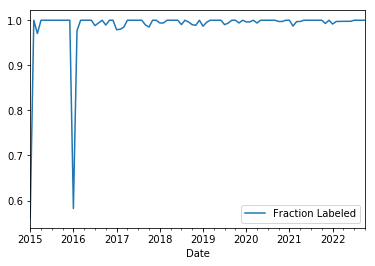

In [23]:
station_race_counts_df = pd.DataFrame(station_race_counts).set_index("Date")
station_race_counts_df.plot(y = "Fraction Labeled")

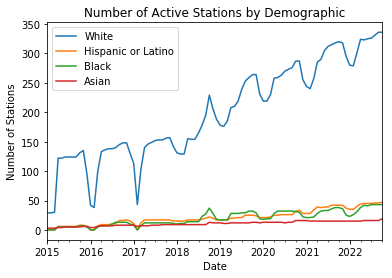

In [32]:
fig, ax = plt.subplots()
station_race_counts_df[["White", "Hispanic or Latino", "Black", "Asian"]].plot(ax = ax)
ax.set_ylabel("Number of Stations")
ax.set_title("Number of Active Stations by Demographic")
plt.savefig("figs/stations_by_demographic.pdf", bbox_inches="tight")
#ax.set_yscale("log")

In [27]:
station_race_counts[-1]

{'Hispanic or Latino': 47,
 'White': 336,
 'Black': 43,
 'American Indian': 0,
 'Asian': 19,
 'Date': datetime.datetime(2022, 10, 1, 0, 0),
 'Fraction Labeled': 1.0}

In [21]:
counts = {race: 0 for race in races}
counts["NA"] = 0

for node in rides_G:
    counts[rides_G.nodes[node]["Race"]] += 1
counts

{'Hispanic or Latino': 47,
 'White': 336,
 'Black': 43,
 'American Indian': 0,
 'Asian': 19,
 'NA': 0}

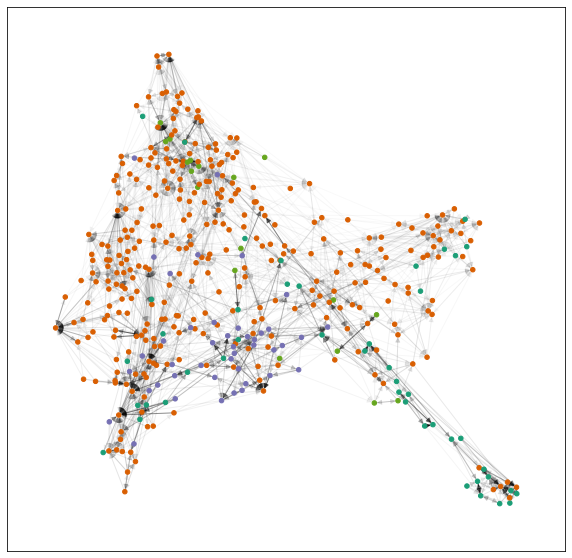

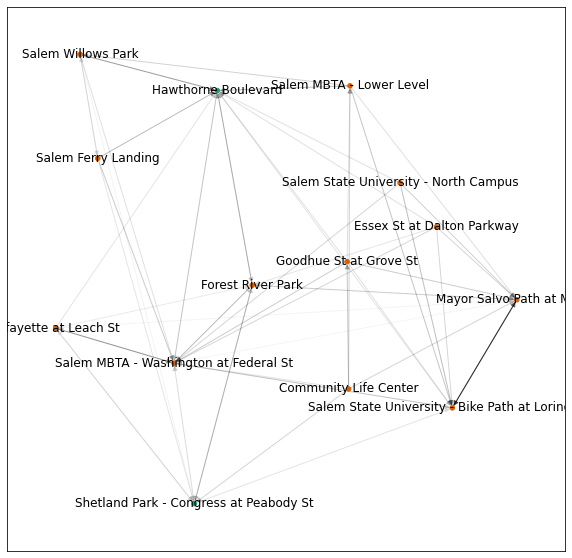

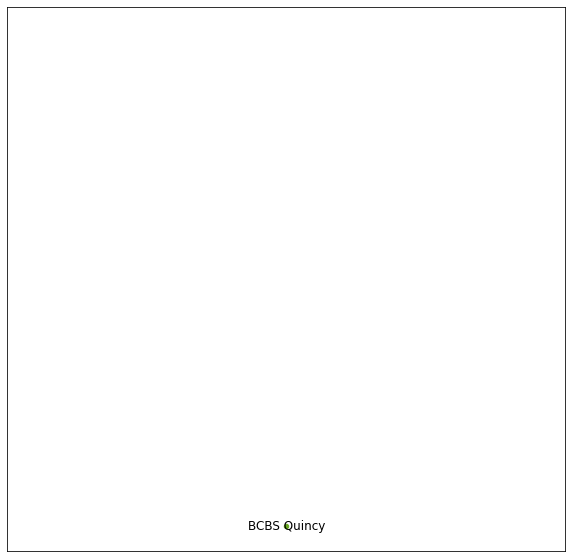

In [22]:
rides_small_G = nx.DiGraph()
rides_small_G.add_nodes_from(rides_G.nodes(data=True))
k = 5

color_map = {
    "Hispanic or Latino": "#1b9e77",
    "White": "#d95f02",
    "Black": "#7570b3", 
    "American Indian": "#e7298a", 
    "Asian": "#66a61e",
    "NA": "#e6ab02" 
}
for origin in rides_G:
    destinations_by_weight = [(dest, rides_G[origin][dest]["weight"]) for dest in rides_G.neighbors(origin)]
    destinations_by_weight = sorted(destinations_by_weight, key=lambda dest: dest[1])
    if len(destinations_by_weight) < k:
        for dest in destinations_by_weight:
            rides_small_G.add_edge(origin, dest[0], weight=dest[1])
    else:
        for dest in destinations_by_weight[-5:]:
            rides_small_G.add_edge(origin, dest[0], weight=dest[1])
len(rides_small_G)
len(rides_small_G.edges)
for com in nx.weakly_connected_components(rides_small_G):
    fig, ax = plt.subplots(figsize=(10, 10))
    with_labels = False
    if len(com) < 100:
        with_labels = True
    
    component_G = rides_small_G.subgraph(com)
    nx.draw_networkx(component_G, node_size=20,
                     node_color = [color_map[rides_small_G.nodes[node]["Race"]] for node in component_G],
                     edge_color = [(0, 0, 0, rides_small_G[u][v]["weight"]) for u, v in component_G.edges()],
                     with_labels=with_labels, ax=ax)

In [21]:
station_census_pd["Station Id"]

0       59
1      365
2      302
3      317
4      587
      ... 
510    120
511     42
512    476
513    296
514    146
Name: Station Id, Length: 515, dtype: int64

In [ ]:
# Origin/Destination, Station Name, Path ID, Lat, Long, Weight
rides_small_edges = []
for origin_name, dest_name in rides_small_G.edges:
    origin_id = station_name_to_id[origin_name]
    dest_id = station_name_to_id[dest_name]
    
    path_id = "{}-{}".format(origin_id, dest_id)
    rides_small_edges.append({"Origin/Destination": "Origin",
                             "Station Name": origin_name,
                             "Path Id": path_id,
                             "Lat": unique_stations_pd.loc[origin_id]["start station latitude"],
                             "Long": unique_stations_pd.loc[origin_id]["start station longitude"],
                             "Weight": rides_small_G[origin_name][dest_name]["weight"]})
    rides_small_edges.append({"Origin/Destination": "Destination",
                         "Station Name": dest_name,
                         "Path Id": path_id,
                         "Lat": unique_stations_pd.loc[dest_id]["start station latitude"],
                         "Long": unique_stations_pd.loc[dest_id]["start station longitude"],
                         "Weight": rides_small_G[origin_name][dest_name]["weight"]})

In [ ]:
pd.DataFrame(rides_small_edges).to_csv("temp/top_five_pairs.csv")

## Travel Time Preliminary

In [ ]:
path_summary_pd = rides_pd[rides_pd["invalid"] == False]\
                    .groupby(["pathid"])\
                    .agg({"tripduration": ["mean", "std", "count"]})
high_var_paths_pd = path_summary_pd[(path_summary_pd["tripduration"]["count"] > 100)\
                                       & (path_summary_pd["tripduration"]["std"] > 20 * 60)]

num_paths = 0
max_std = -1
max_std_path = None
for pathid in high_var_paths_pd.index:
    origin_id, dest_id = pathid.split("-")
    if origin_id == dest_id:
        continue
    origin_name = station_id_to_name[origin_id]
    dest_name = station_id_to_name[dest_id]
    path_std = high_var_paths_pd.loc[pathid]["tripduration"]["std"] / 60
    print("Start: {}({}) Stop: {}({}) Std: {}".format(origin_name,
                                             origin_id,
                                             dest_name,
                                             dest_id,
                                             path_std))
    if path_std > max_std:
        max_std = path_std
        max_std_path = "{}-{}".format(origin_id, dest_id)
    num_paths += 1

print(num_paths)
print(max_std_path)

In [ ]:
weekday_vs_weekend_pd = rides_pd[rides_pd["invalid"] == False]\
                    .groupby(["pathid", "is_weekday"])\
                    .count()
weekday_increase_dict = {}
dates = np.unique(rides_pd["startdate"])
num_weekdays = np.sum([d.weekday() < 5 for d in dates])
num_weekends = len(dates) - num_weekdays
num_weekdays, num_weekends
for pathid in np.unique(rides_pd["pathid"]):
    try:
        num_weekday_trips = weekday_vs_weekend_pd.loc[pathid, True]["tripduration"] / num_weekdays
        num_weekend_trips = weekday_vs_weekend_pd.loc[pathid, False]["tripduration"] / num_weekends
        weekday_increase_percent = 100 * ((num_weekday_trips - num_weekend_trips) / num_weekend_trips)
        weekday_increase_dict[pathid] = {"Percent Increase": weekday_increase_percent,
                                        "Total Trips": num_weekday_trips + num_weekend_trips}
    except:
        continue

In [ ]:
#Export path data
paths = []
# paths with trips on both weekdays and weekend in Oct
for pathid in path_summary_pd.index:
    origin_id, dest_id = pathid.split("-")
    origin_name = station_id_to_name[origin_id]
    dest_name = station_id_to_name[dest_id]
    
    weekday_increase = 0
    if pathid in weekday_increase_dict:
        weekday_increase = weekday_increase_dict[pathid]["Percent Increase"]
        
    paths.append({"Origin/Destination": "Origin",
                             "Station Name": origin_name,
                             "Path Id": pathid,
                             "Lat": unique_stations_pd.loc[origin_id]["start station latitude"],
                             "Long": unique_stations_pd.loc[origin_id]["start station longitude"],
                             "Weekday Increase": weekday_increase,
                             "Number of Rides": path_summary_pd.loc[pathid]["tripduration"]["count"],
                             "Ride Duration Mean": path_summary_pd.loc[pathid]["tripduration"]["mean"],
                             "Ride Duration Std Dev.": path_summary_pd.loc[pathid]["tripduration"]["std"]})
    paths.append({"Origin/Destination": "Destination",
                         "Station Name": dest_name,
                         "Path Id": pathid,
                         "Lat": unique_stations_pd.loc[dest_id]["start station latitude"],
                         "Long": unique_stations_pd.loc[dest_id]["start station longitude"],
                         "Weekday Increase": weekday_increase,
                         "Number of Rides": path_summary_pd.loc[pathid]["tripduration"]["count"],
                         "Ride Duration Mean": path_summary_pd.loc[pathid]["tripduration"]["mean"],
                         "Ride Duration Std Dev.": path_summary_pd.loc[pathid]["tripduration"]["std"]})


In [ ]:
paths[2]

In [ ]:
pd.DataFrame(paths).to_csv("temp/paths.csv")

In [ ]:
paths_pd = pd.DataFrame(paths)

In [ ]:
paths_pd[paths_pd["Number of Rides"] > 100].sort_values("Weekday Increase")

In [ ]:
paths_pd.sort_values("Number of Rides")

In [ ]:
paths_pd[paths_pd["Number of Rides"] > 50].sort_values("Ride Duration Mean").tail(20)

In [ ]:
paths_pd[paths_pd["Number of Rides"] > 100].sort_values("Ride Duration Std Dev.").tail(20)

## Extract Stations

In [ ]:
station_ids = set()
station_metadata = []
for year in range(2015, 2023):
    for month in range(1, 13):
        if year == 2022 and month > 10:
            continue

        rides_pd = load_pd(year, month)
        for i in range(len(rides_pd)):
            stationid = rides_pd.iloc[i]["start station id"]
            if stationid not in station_ids and stationid != "\\N":
                station_ids.add(stationid)
                station_metadata.append({
                    "id": stationid,
                    "Name": rides_pd.iloc[i]["start station name"],
                    "Lat": rides_pd.iloc[i]["start station latitude"],
                    "Long": rides_pd.iloc[i]["start station longitude"]
                })
            
            stationid = rides_pd.iloc[i]["end station id"]
            if stationid not in stationids and stationid != "\\N":
                stationids.add(stationid)
                station_metadata.append({
                    "id": stationid,
                    "Name": rides_pd.iloc[i]["end station name"],
                    "Lat": rides_pd.iloc[i]["end station latitude"],
                    "Long": rides_pd.iloc[i]["end station longitude"]
                })
        print("{} {}".format(year, month))

In [9]:
pd.DataFrame(station_metadata).to_csv("stations.csv")

In [10]:
len(station_metadata)

523